# Parallax & Proper Motion

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from astropy import units
from astropy.coordinates import SkyCoord, Distance, CIRS
from astropy.time import Time
from astroquery.simbad import Simbad

In [2]:
# query SIMBAD database
simbad = Simbad()
simbad.reset_votable_fields()
simbad.add_votable_fields("pm", "parallax")
table = simbad.query_object("Vega")
assert len(table) == 1

# convert to SkyCoord object
vega = table[0]
vega = SkyCoord(
    ra=vega["RA"],
    dec=vega["DEC"],
    unit=(units.hourangle, units.deg),
    pm_ra_cosdec=vega["PMRA"] * units.mas/units.yr,
    pm_dec=vega["PMDEC"] * units.mas/units.yr,
    distance=Distance(parallax=vega["PLX_VALUE"] * units.mas),
    obstime="J2000")

In [3]:
print(vega)

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, pc)
    (279.23473458, 38.78368889, 7.67872226)
 (pm_ra_cosdec, pm_dec) in mas / yr
    (200.94, 286.23)>


In [4]:
t_obs = vega.obstime + np.linspace(0, 5, 500) * units.yr
t_obs.format = "jyear"
vega_obs = vega.apply_space_motion(t_obs)

frame = CIRS(obstime=t_obs)
vega_obs = vega_obs.transform_to(frame)

In [5]:
# artificial background object
vega_fix = SkyCoord(
    ra=vega.ra,
    dec=vega.dec,
    distance=1*units.Tpc) # "far"

vega_fix = vega_fix.transform_to(frame)

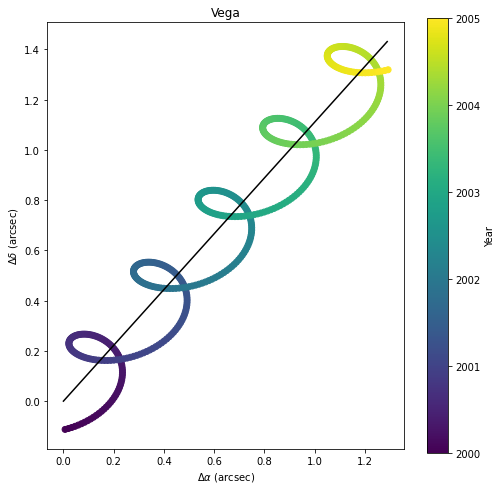

In [6]:
fig, ax = plt.subplots(figsize=(8, 8))

# motion relative to background object
dra = vega_obs.ra - vega_fix.ra
ddec = vega_obs.dec - vega_fix.dec
dt = t_obs - vega.obstime

cax = ax.scatter(dra.arcsec, ddec.arcsec, c=t_obs.value)
plt.colorbar(cax, label="Year")

dra_lin = (vega.pm_ra_cosdec/np.cos(vega.dec) * dt).to(units.arcsec)
ddec_lin = (vega.pm_dec * dt).to(units.arcsec)

ax.plot(dra_lin, ddec_lin, c="k")

ax.set_aspect("equal")

ax.set_title("Vega")
ax.set_xlabel(r"$\Delta\alpha$ (arcsec)")
ax.set_ylabel(r"$\Delta\delta$ (arcsec)")

plt.show()